# Exploratory Data Analysis

This notebook explores the building footprint dataset.

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
from tqdm import tqdm

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Manifest

In [3]:
manifest_path = project_root / 'data' / 'manifest.csv'

if manifest_path.exists():
    df = pd.read_csv(manifest_path)
    print(f'Total images: {len(df)}')
    df.head()

Total images: 2780


## 2. Dataset Statistics

Images per city:
city
Shanghai    1198
Vegas        989
Paris        310
Khartoum     283
Name: count, dtype: int64


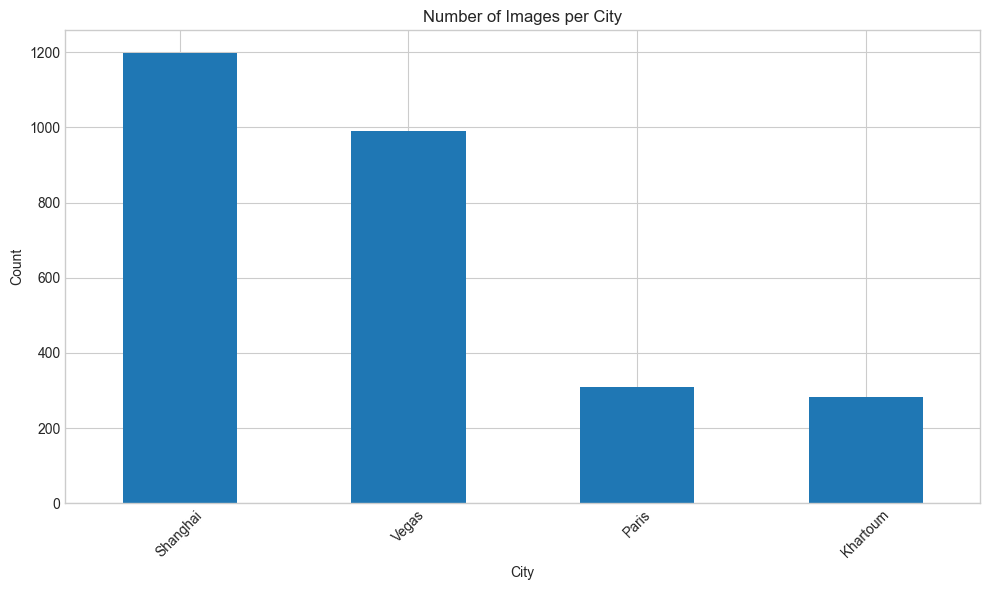

In [4]:
if 'df' in dir():
    print('Images per city:')
    print(df['city'].value_counts())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    df['city'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title('Number of Images per City')
    ax.set_xlabel('City')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 3. Image Size Distribution

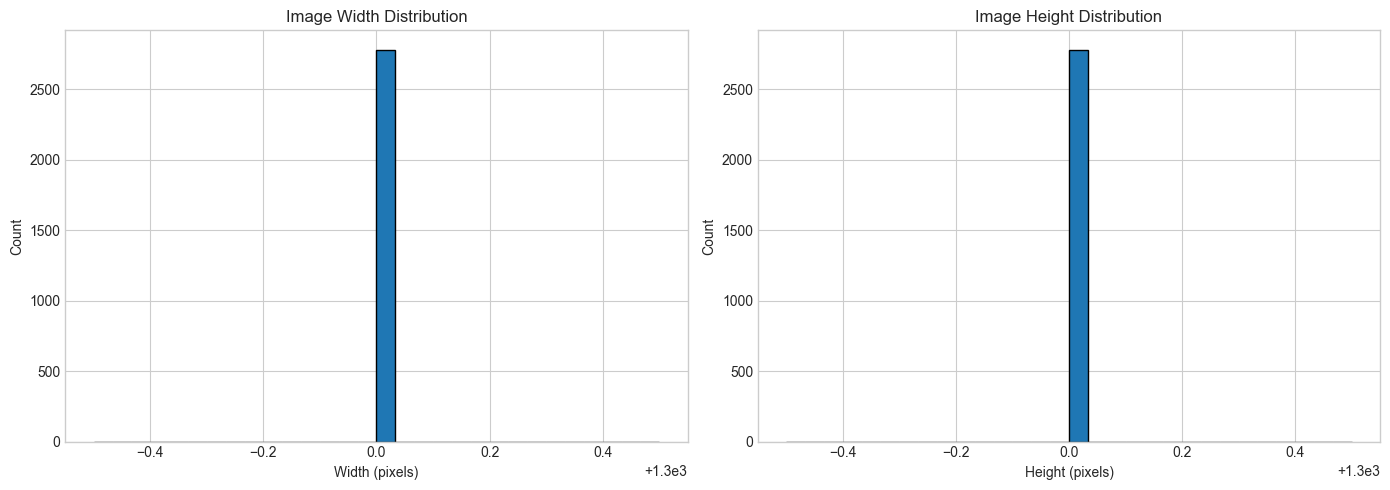

In [5]:
if 'df' in dir() and 'width' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(df['width'], bins=30, edgecolor='black')
    axes[0].set_title('Image Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Count')
    
    axes[1].hist(df['height'], bins=30, edgecolor='black')
    axes[1].set_title('Image Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

## 4. Sample Images

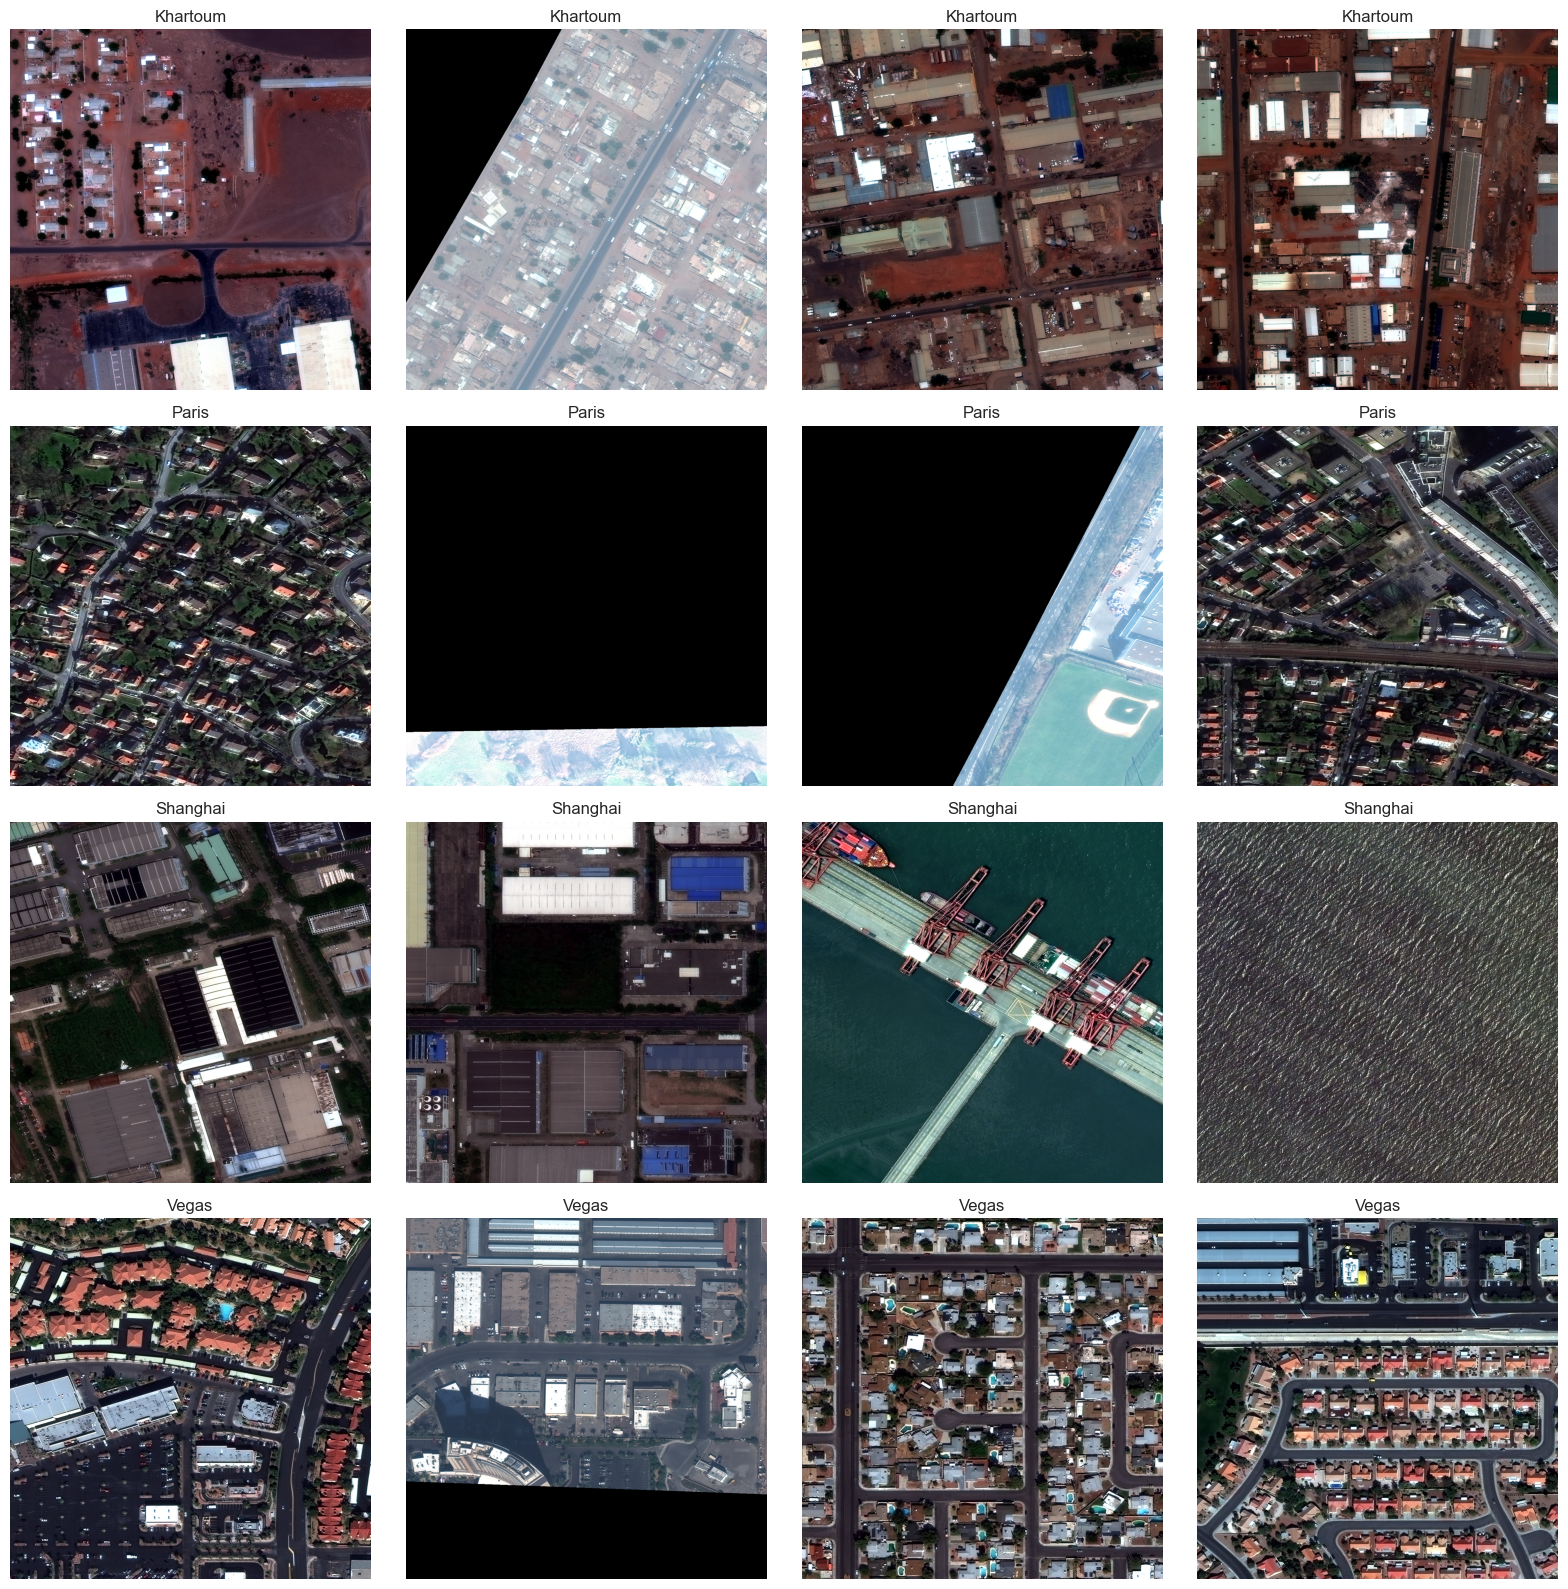

In [10]:
def show_sample_images(df, base_path, n_samples=4):
    """Display sample images from each city."""
    cities = df['city'].unique()
    
    fig, axes = plt.subplots(len(cities), n_samples, figsize=(16, 4*len(cities)))
    
    for i, city in enumerate(cities):
        city_df = df[df['city'] == city]
        city_df = city_df[city_df['image_path'].apply(lambda x: (base_path / x).exists())]
        city_df = city_df.sample(min(n_samples, len(city_df)))
        
        for j, (_, row) in enumerate(city_df.iterrows()):
            if j >= n_samples:
                break
            
            try:
                full_path = base_path / row['image_path']
                with rasterio.open(full_path) as src:
                    img = src.read([1, 2, 3])
                    img = np.transpose(img, (1, 2, 0))
                    
                    if img.max() > 1:
                        img = img / 255.0
                    
                    ax = axes[i, j] if len(cities) > 1 else axes[j]
                    ax.imshow(img)
                    ax.set_title(f'{city}')
                    ax.axis('off')
            except Exception as e:
                print(f'Error loading {row["image_path"]}: {e}')
    
    plt.tight_layout()
    plt.show()

if 'df' in dir():
    show_sample_images(df, project_root)

## 5. Building Statistics

In [11]:
def analyze_annotations(df, base_path, sample_size=50):
    """Analyze building annotations."""
    building_counts = []
    building_areas = []
    
    sample_df = df.sample(min(sample_size, len(df)))
    
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        annotation_path = row.get('annotation_path', '')
        
        if pd.isna(annotation_path) or not annotation_path:
            continue
        
        full_path = base_path / annotation_path
        if not full_path.exists():
            continue
        
        try:
            gdf = gpd.read_file(full_path)
            building_counts.append(len(gdf))
            building_areas.extend(gdf.geometry.area.tolist())
        except Exception as e:
            print(f'Error reading {annotation_path}: {e}')
    
    return building_counts, building_areas

if 'df' in dir():
    counts, areas = analyze_annotations(df, project_root)
    
    if counts:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].hist(counts, bins=30, edgecolor='black')
        axes[0].set_title('Buildings per Image')
        axes[0].set_xlabel('Number of Buildings')
        axes[0].set_ylabel('Count')
        
        if areas:
            axes[1].hist(areas, bins=50, edgecolor='black')
            axes[1].set_title('Building Area Distribution')
            axes[1].set_xlabel('Area')
            axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()
        
        print(f'Average buildings per image: {np.mean(counts):.1f}')
        print(f'Max buildings per image: {np.max(counts)}')
        print(f'Min buildings per image: {np.min(counts)}')

100%|██████████| 50/50 [00:00<00:00, 9991.67it/s]


## 6. Sample with Overlay

City: Khartoum


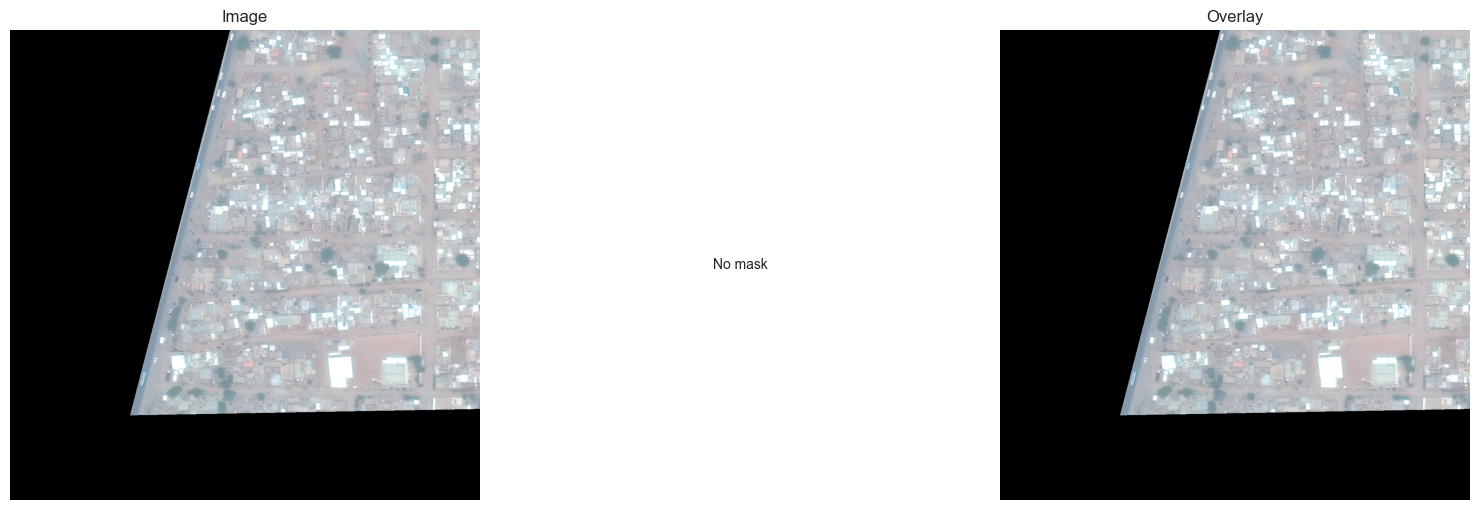

City: Khartoum


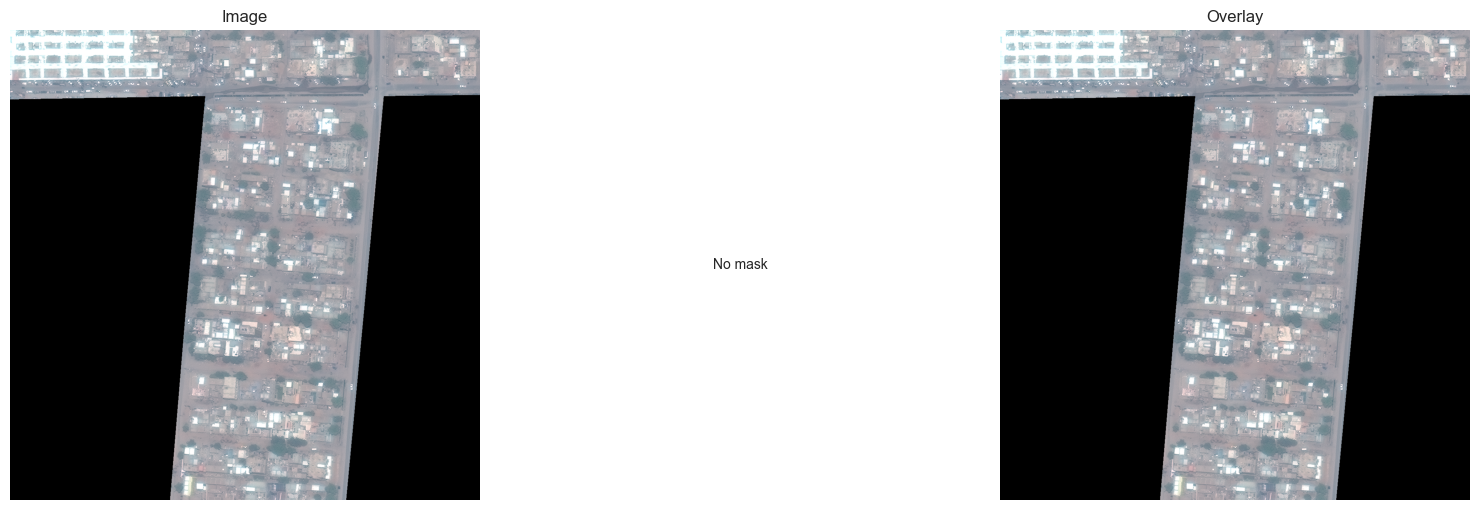

City: Khartoum


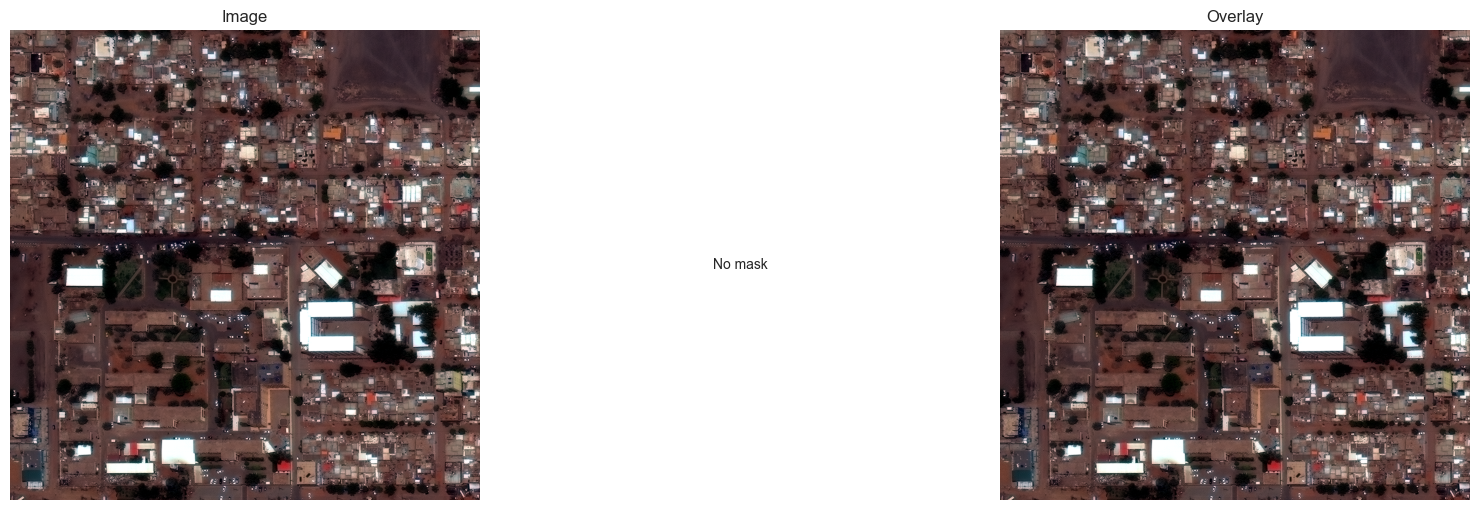

City: Khartoum


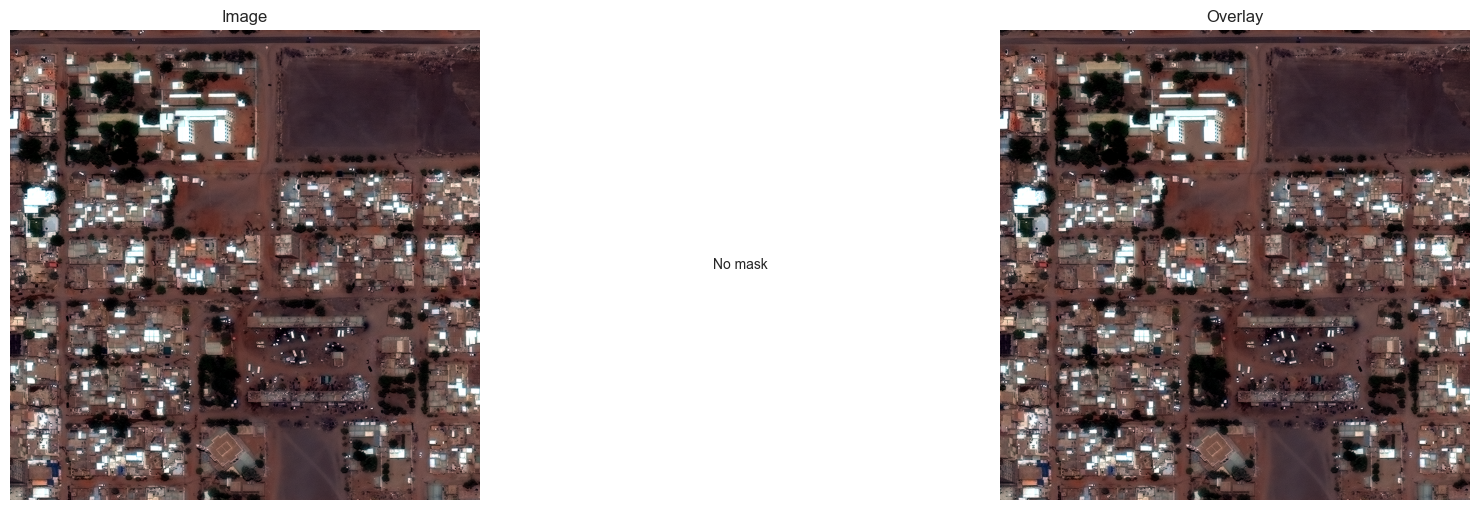

In [13]:
def show_image_with_mask(image_path, mask_path=None, annotation_path=None, base_path=None):
    """Show image with mask or annotation overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    if base_path:
        image_path = base_path / image_path
        if mask_path and not pd.isna(mask_path):
            mask_path = base_path / mask_path
        else:
            mask_path = None
        if annotation_path and not pd.isna(annotation_path):
            annotation_path = base_path / annotation_path
        else:
            annotation_path = None
    
    try:
        with rasterio.open(image_path) as src:
            img = src.read([1, 2, 3])
            img = np.transpose(img, (1, 2, 0))
            if img.max() > 1:
                img = img / 255.0
        
        axes[0].imshow(img)
        axes[0].set_title('Image')
        axes[0].axis('off')
    except Exception as e:
        print(f'Error loading image: {e}')
        axes[0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', fontsize=8)
        axes[0].axis('off')
        return
    
    if mask_path and Path(mask_path).exists():
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No mask', ha='center', va='center')
        axes[1].axis('off')
    
    axes[2].imshow(img)
    if annotation_path and Path(annotation_path).exists():
        gdf = gpd.read_file(annotation_path)
        gdf.boundary.plot(ax=axes[2], color='red', linewidth=1)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

if 'df' in dir() and len(df) > 0:
    sample_df = df[df['image_path'].apply(lambda x: (project_root / x).exists())].head(4)
    
    for _, row in sample_df.iterrows():
        print(f"City: {row['city']}")
        show_image_with_mask(
            row['image_path'],
            annotation_path=row.get('annotation_path'),
            base_path=project_root
        )